# Semi-Supervised Learning with VAE on Fashion MNIST

This notebook implements semi-supervised learning using Variational Autoencoders (VAEs) on the Fashion MNIST dataset, followed by training an SVM classifier using the features extracted from the VAE. We experiment with different numbers of labeled examples to evaluate the performance of our semi-supervised approach.

## 1. Setup

Start by importing the necessary libraries and setting up the environment.


In [1]:
# Import necessary libraries
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from data.cifar10_data import get_cifar10_data
from data.mnist_data import get_mnist_data, get_fashion_mnist_data
from model.dcgan import DCGAN
from model.wgan import WGAN
from torch.utils.tensorboard import SummaryWriter


%load_ext autoreload
%autoreload 2



## 2. Hyperparameters

Here, we define the hyperparameters for our experiments.


In [2]:
# Hyperparameters
gan_train_config= {
    'dcgan':{'nz': 128,
             'lr': 5e-4,
             'n_iter': 1500,
             'gan_type': 'dcgan'},
    
    'wgan': {'nz': 128,
             'lr': 5e-4,
             'n_critic': 5,
             'clamp_value': 0.01,
             'n_iter': 5000,
             'lambda_gp': 10,
             'gan_type': 'wgan'}}

dataset = 'fashion_mnist'  # mnist/fashion_mnist/cifar10
batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Reproduce results by seed:
seed = 205917883
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## 3. Dataset Handling


In [ ]:
# Get data loader
if dataset == 'cifar10':
    data_loader = get_cifar10_data(batch_size)
    channels = 3
elif dataset == 'mnist':
    data_loader = get_mnist_data(batch_size)
    channels = 1
elif dataset == 'fashion_mnist':
    data_loader = get_fashion_mnist_data(batch_size)
    channels = 1
else:
    raise ValueError("Invalid dataset")


## Training

In [53]:
# Function to plot generated samples
def plot_generated_samples(step, noise, gan):
    with torch.no_grad():
        fake_images = gan.generator(noise).detach().cpu()

    # Handle both grayscale and RGB images
    if fake_images.shape[1] == 1:
        fake_images = fake_images.repeat(1, 3, 1, 1)  # Convert grayscale to RGB for plotting

    grid = torchvision.utils.make_grid(fake_images, padding=2, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f'Generated Images at Step {step}')
    plt.axis('off')  # Hide axis
    plt.show()
    
    return grid

In [54]:
def train_gan(config, device, data_loader):
    gan_type = config['gan_type']
    nz = config['nz']
    lr = config['lr']
    n_iter = config['n_iter']
    channels = 1 if dataset in ['mnist', 'fashion_mnist'] else 3
    clamp_value = config.get('clamp_value', None)
    n_critic = config.get('n_critic', 1)
    writer = SummaryWriter()

    if gan_type == 'wgan':
        gan = WGAN(nz, lr, device, channels=channels, clamp_value=clamp_value, n_critic=n_critic)
    else:
        gan = DCGAN(nz, lr, device, channels=channels)

    fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)  # Fixed noise for consistent samples

    # Lists to store losses
    D_losses = []
    G_losses = []

    # Training loop
    data_iter = iter(data_loader)
    pbar = tqdm(range(n_iter))

    for step in pbar:
        if gan_type == 'wgan':
            for p in gan.discriminator.parameters():
                p.requires_grad = True

        for i in range(gan.n_critic if gan_type == 'wgan' else 1):
            try:
                real_data = next(data_iter)
            except StopIteration:
                # Start next epoch over data
                data_iter = iter(data_loader)
                real_data = next(data_iter)

            real_data = real_data[0].to(device)
            noise = torch.randn(real_data.shape[0], nz, 1, 1, device=device)
            fake_data = gan.generator(noise)

            D_loss = gan.train_discriminator(real_data, fake_data)
            D_losses.append(D_loss.item())

        if gan_type == 'wgan':
            for p in gan.discriminator.parameters():
                p.requires_grad = False

        G_loss = gan.train_generator(fake_data)
        G_losses.append(G_loss.item())

        # Log losses to TensorBoard
        writer.add_scalar('Loss/Discriminator', D_loss.item(), step)
        writer.add_scalar('Loss/Generator', G_loss.item(), step)

        # Update tqdm progress bar
        pbar.set_description(f"Step [{step}/{n_iter}] | D_loss: {D_loss.item():.3f} | G_loss: {G_loss.item():.3f}")

        # Plot generated samples
        if step % 500 == 0:
            grid = plot_generated_samples(step, fixed_noise, gan)
            writer.add_image(f'Generated Images at Step {step}', grid, step)

    # Close TensorBoard writer
    writer.close()

    # Save the models
    save_path = './saved_models'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    torch.save(gan.generator.state_dict(), os.path.join(save_path, f'{gan_type}_generator.pth'))
    torch.save(gan.discriminator.state_dict(), os.path.join(save_path, f'{gan_type}_discriminator.pth'))

    return gan, D_losses, G_losses

In [55]:
def plot_loss_curves(D_losses, G_losses):

    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(D_losses, label='Discriminator Loss', color='blue', linewidth=0.5, alpha=0.6)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Discriminator Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(G_losses, label='Generator Loss', color='green', linewidth=0.5, alpha=0.6)
    ax2.set_ylabel('Generator Loss', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    plt.title('Training Losses')
    plt.tight_layout()
    plt.show()


### Train DCGAN

Step [0/1500] | D_loss: 1.568 | G_loss: 5.090:   0%|          | 0/1500 [00:00<?, ?it/s]

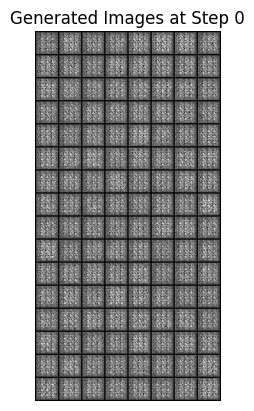

Step [500/1500] | D_loss: 0.881 | G_loss: 1.686:  33%|███▎      | 500/1500 [00:42<01:23, 12.01it/s]

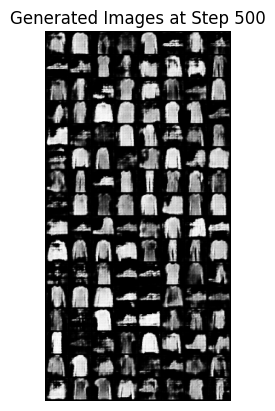

Step [1000/1500] | D_loss: 1.050 | G_loss: 0.806:  67%|██████▋   | 1000/1500 [01:25<00:42, 11.74it/s]

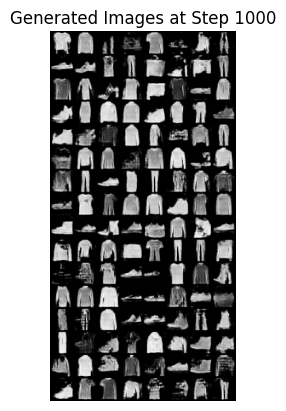

Step [1499/1500] | D_loss: 1.125 | G_loss: 3.882: 100%|██████████| 1500/1500 [02:08<00:00, 11.64it/s]


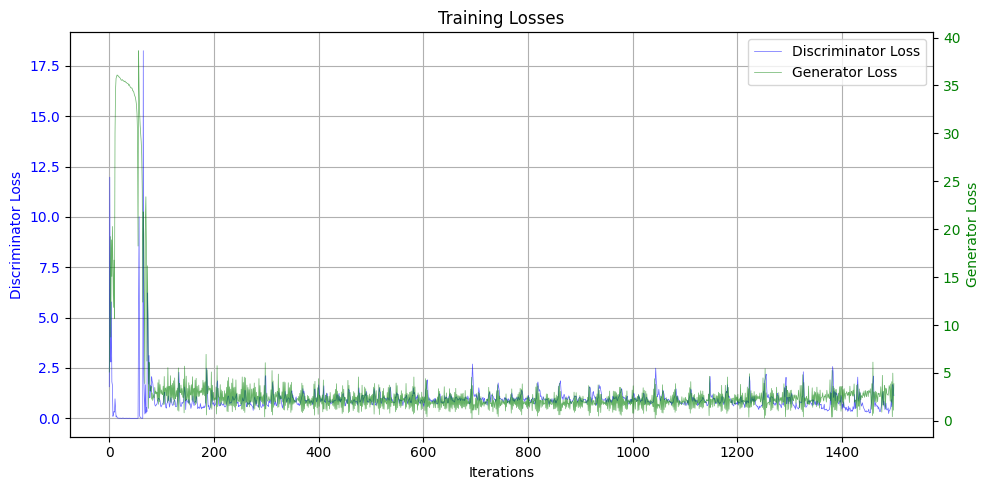

In [56]:
config = gan_train_config['dcgan']
gan, D_losses, G_losses = train_gan(config, device, data_loader)
plot_loss_curves(D_losses, G_losses)

### Train WGAN

Step [0/5000] | D_loss: 0.001 | G_loss: 0.001:   0%|          | 0/5000 [00:00<?, ?it/s]

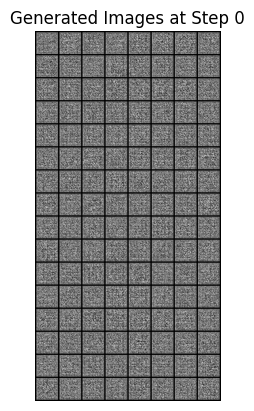

Step [500/5000] | D_loss: -0.079 | G_loss: 0.213:  10%|█         | 500/5000 [02:33<24:16,  3.09it/s]

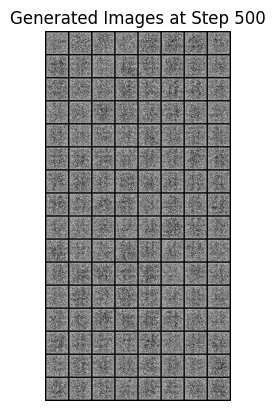

Step [1000/5000] | D_loss: -0.042 | G_loss: 0.402:  20%|██        | 1000/5000 [05:08<20:45,  3.21it/s]

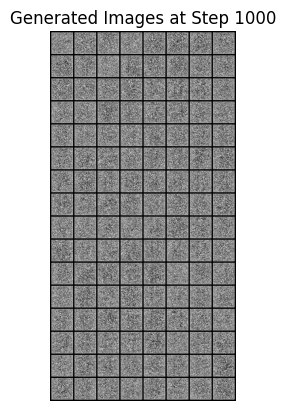

Step [1500/5000] | D_loss: -0.034 | G_loss: 0.542:  30%|███       | 1500/5000 [07:44<18:13,  3.20it/s]

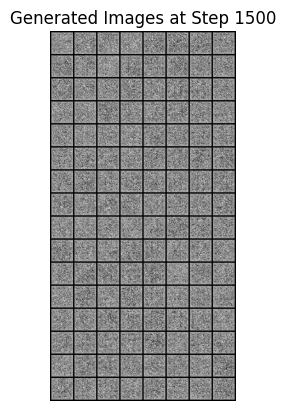

Step [2000/5000] | D_loss: -0.029 | G_loss: 0.674:  40%|████      | 2000/5000 [10:20<15:27,  3.23it/s]

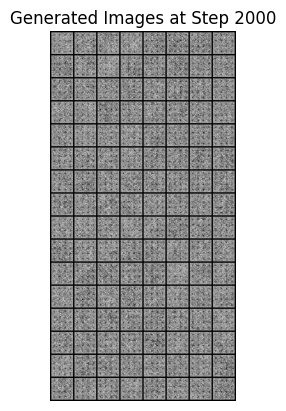

Step [2500/5000] | D_loss: -0.023 | G_loss: 0.746:  50%|█████     | 2500/5000 [12:57<12:55,  3.22it/s]

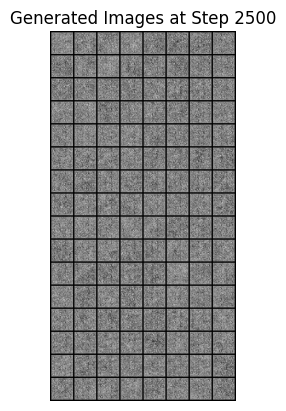

Step [3000/5000] | D_loss: -0.017 | G_loss: 0.800:  60%|██████    | 3000/5000 [15:33<10:30,  3.17it/s]

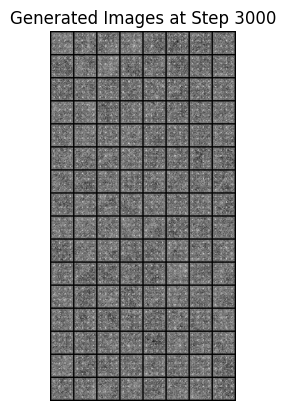

Step [3500/5000] | D_loss: -0.013 | G_loss: 0.848:  70%|███████   | 3500/5000 [18:10<07:47,  3.21it/s]

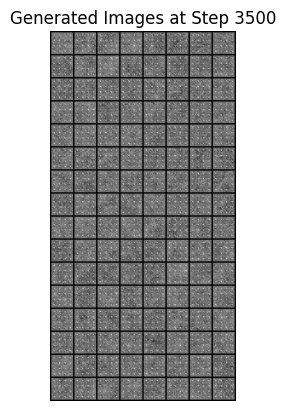

Step [4000/5000] | D_loss: -0.010 | G_loss: 0.893:  80%|████████  | 4000/5000 [20:47<05:13,  3.19it/s]

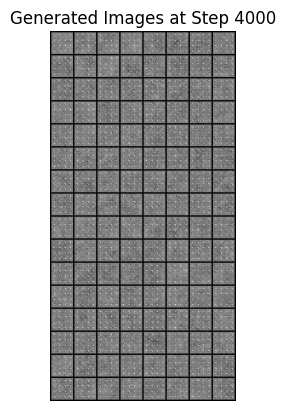

Step [4500/5000] | D_loss: -0.009 | G_loss: 0.911:  90%|█████████ | 4500/5000 [23:23<02:36,  3.20it/s]

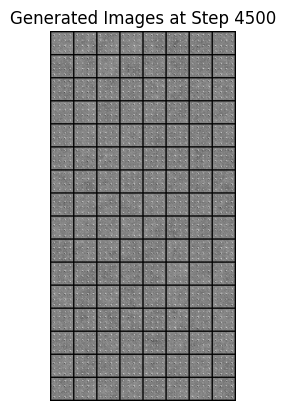

Step [4999/5000] | D_loss: -0.008 | G_loss: 0.925: 100%|██████████| 5000/5000 [25:59<00:00,  3.21it/s]


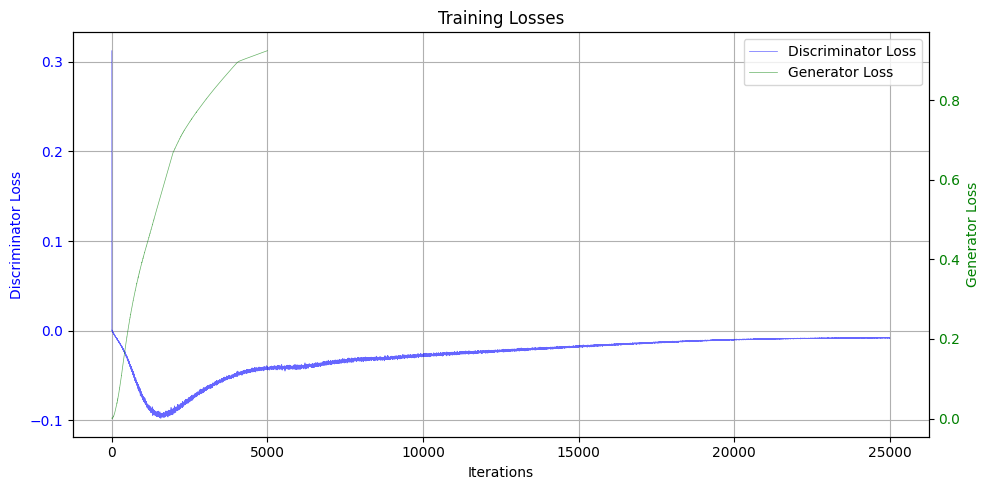

In [93]:
config = gan_train_config['wgan']
gan, D_losses, G_losses = train_gan(config, device, data_loader)
plot_loss_curves(D_losses, G_losses)

## Evaluation

In [62]:
# Load the saved model and plot fake samples
def load_and_plot_samples(generator_path, net_config, device, data_loader, num_samples=64, gan_type='dcgan'):
    nz = net_config['nz']
    lr = net_config['lr']
    if gan_type == 'wgan':
        gan = WGAN(nz, lr, device, channels=channels, clamp_value=clamp_value, n_critic=n_critic)
    else:
        gan = DCGAN(nz, lr, device, channels=channels)
    
    gan.generator.load_state_dict(torch.load(generator_path, map_location=device))
    gan.generator.eval()

    with torch.no_grad():
        noise = torch.randn(num_samples, nz, 1, 1, device=device)
        fake_images = gan.generator(noise).cpu()

    # Get real samples
    real_data = next(iter(data_loader))[0][:2]  # Get the first batch and take the first two samples

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(15, 5))

    # Plot Generated Images
    axes[0].imshow(torchvision.utils.make_grid(fake_images, padding=2, normalize=True).permute(1, 2, 0))
    axes[0].set_title('Generated Images')
    axes[0].axis('off')

    # Plot Real Images
    axes[1].imshow(torchvision.utils.make_grid(real_data, padding=2, normalize=True).permute(1, 2, 0))
    axes[1].set_title('Real Images')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


### Evaluate DCGAN

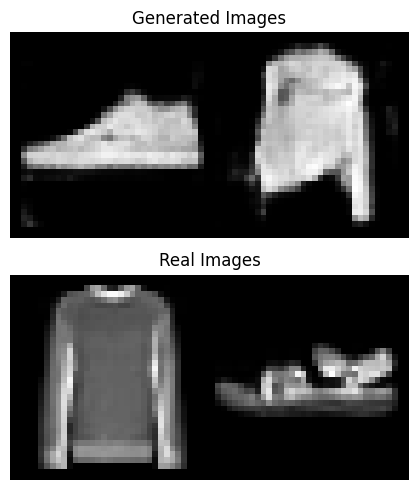

In [77]:
save_path = './saved_models'
generator_path = os.path.join(save_path, f'dcgan_generator.pth')
load_and_plot_samples(generator_path, gan_train_config['dcgan'], device, data_loader=data_loader,num_samples=2)

### Evaluate DCGAN

In [ ]:
generator_path = os.path.join(save_path, f'wgan_generator.pth')
load_and_plot_samples(generator_path, nz, device, data_loader=data_loader,num_samples=2)

FileNotFoundError: [Errno 2] No such file or directory: './saved_models/wgan_generator.pth'